In [1]:
from IPython.display import Image

from matplotlib import pyplot as plt
import numpy as np
from numpy.random import normal, binomial, choice
import pandas as pd
from scipy import stats
import seaborn as sns

from rl2e.ch2 import bandits


px = 1 / plt.rcParams["figure.dpi"]  # pixel in inches
plt.rcParams["figure.figsize"] = (600 * px, 400 * px)
%matplotlib widget

## 2.1 K-armed Bandit Problems

- In this chapter we study evaluative feedback in RL in a simplified setting: a **nonassociative** setting in which learning occurs in a single situation (state), known as **K-armed Bandit Problems.**
  - Studying this case distinguishes how evaluative feedback (in RL) differs from, and yet can be combined with, instructive feedback (in supervised learning)
- A k-armed bandit problem takes its name from a slot machine with "k" levers, each with a different probability of being rewarded at any given time.
  - Each of the $k$ actions has a **value** (E.V.) given that action is selected. If $A_t$ is the action and $R_t$ the subsequent reward selected at time-step $t$, then the value of an action $a$ is given by: 
  $$\begin{equation}
  q(a) = \mathbb{E}[R_t | A_t=a]
  \end{equation}\tag{2.0}$$
  - If we know the full action-value space at each time-step, then we should always implement a greedy algorithm.

## 2.2 Action-value methods

- If the true value of $a$ is the E.V. of $R$ after $a$ is selected, we can estimate this by the **sample-average** method:
$$\begin{equation}
Q_t(a) = {\sum^{t-1}_{i=1} R_i | A_i=a \over \sum^{t-1}_{i=1} | A_i=a}
\end{equation}\tag{2.1}$$
(we can solve the case where the denominator is 0, i.e. $a$ has never been selected, by setting an initial default value, e.g. 0)
- Greedy action selection is given by: 
$$\begin{equation}
A_t = \underset{a}{\operatorname{argmax}} Q_t(a)
\end{equation}\tag{2.2}$$
- The classic, simple explore-exploit paradigm says to act greedy all of the time except for some small probability, $\epsilon$, where the chosen action is uniform random amongst all possible actions, known as $\epsilon{\text -}greedy$ algorithms.
- If $\epsilon$ decreases over time, we ensure that $Q_t(a)$ converges to $q(a)$.

### 2.2 Exercises

*Exercise 2.1: In $\epsilon$-greedy action selection, for the case of two actions and $\epsilon$=0.5, what is the probability that the greedy action is selected?*

0.5 + (0.5 * 2) = 0.75

## 2.3 The 10-armed Testbed


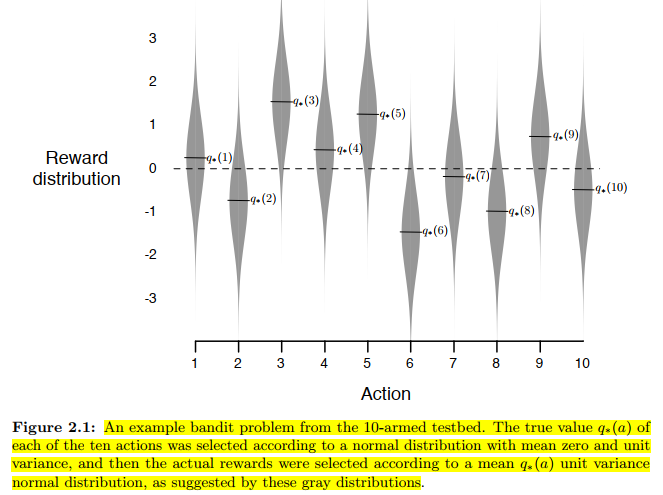

In [2]:
Image(r"images/ten_armed_testbed_distributions.png", width=600, height=400)

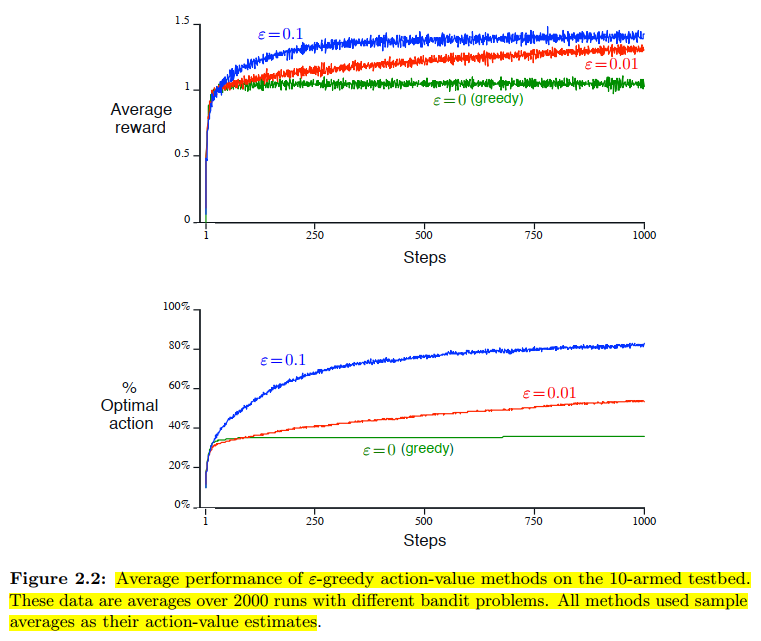

In [3]:
Image(r"images/ten_armed_testbed_performance.png", width=600, height=400)

- The above figures show an example 10-armed bandit problem and the performance of different $\epsilon$=greedy RL agents using the sample-average method for value estimation.
- The relative advantage of each agent depends on the task. The noisier the rewards, the more exploration required to find the optimal action, so the larger $\epsilon$ the better, and vice versa. Additionally, in a **nonstationary** task, where the true values of the actions change over time, exploration is needed.

### 2.3 Exercises

*Exercise 2.2: Bandit example: Consider a k-armed bandit problem with k = 4 actions, denoted 1, 2, 3, and 4. Consider applying to this problem a bandit algorithm using $\epsilon$-greedy action selection, sample-average action-value estimates, and initial estimates of Q1(a) = 0, for all a. Suppose the initial sequence of actions and rewards is*:

A1 = 1, R1 = -1, A2 = 2, R2 = 1, A3 = 2, R3 = -2, A4 = 2, R4 = 2, A5 = 3, R5 = 0. 

*On some of these time steps the $\epsilon$ case may have occurred, causing an action to be selected at random. On which time steps did this definitely occur? On which time steps could this possibly have occurred?*

The $\epsilon$ case definitely occurred on A4, because at this point in time the selected arm (2) has a negative E.V. Technically, all of the actions could be random, the chance of this occuring is $5^{\epsilon}$.

*Exercise 2.3: In the comparison shown in Figure 2.2, which method will perform best in the long run in terms of cumulative reward and probability of selecting the best action? How much better will it be? Express your answer quantitatively.*

$\epsilon$=0.01 will perform better than $\epsilon$=0.1: ten times better. The former should asymptote to 99% (or 99.1%) optimal action, while the latter 90% (or 91%) optimal action.

## 2.4 Incremental Implementation

- How can action-value methods be implemented in a computationally efficient manner? In particular, with constant memory and constant per-time-step computation. 
  - For the **sample-average** method, if $Q_n$ is the value of the nth reward, $R_n$, we can say:
  $$
  \begin{equation}\begin{aligned}
  Q_{n+1} &= {{1 \over n} \sum_{i=1}^{n} R_i} \\
  &= \dots \\
  &= {Q_{n} + {1 \over n} (R_n - Q_n) } 
  \end{aligned}\end{equation}\tag{2.3}
  $$
    - This rule is a form of the same update rule initially defined in chapter 1 $(1.0)$, with the step-size $\alpha$ parameter there being defined as $1 \over n$ here (a function of reward number).

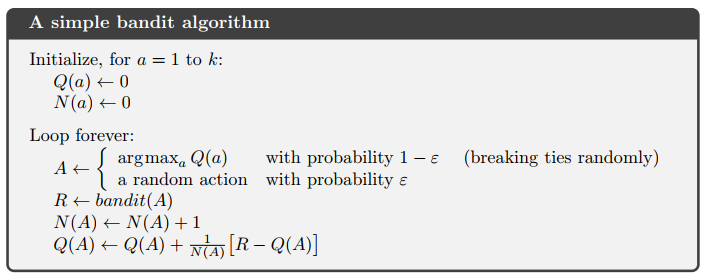

In [4]:
Image(r"images/bandit_algo_pseudocode.png", width=600, height=400)

C:\Users\jai\mambaforge\envs\rl2e\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


Text(0.5, 1.0, 'Running average optimal action probability with step-size 10')

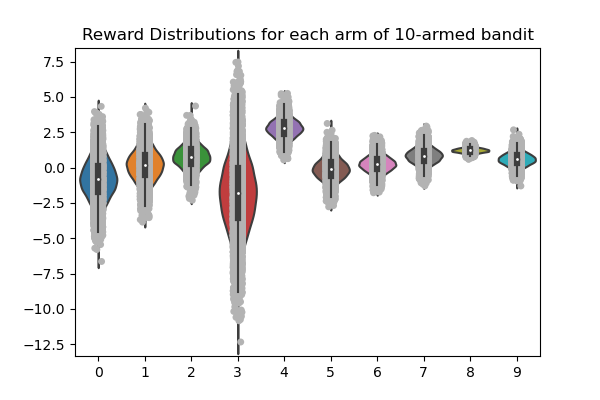

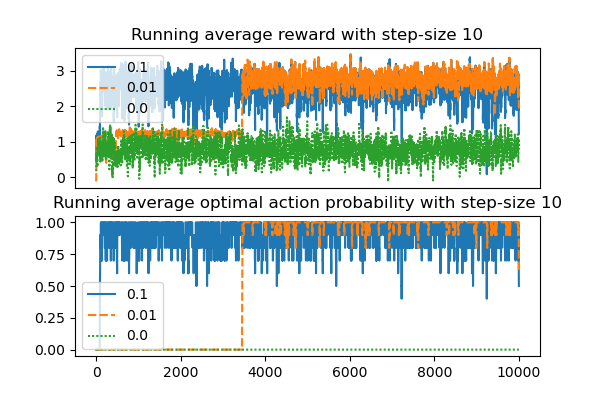

In [5]:
# k-armed bandit testbed example

# Set constants
K = 10  # number of arms
E = np.array((0.1, 0.01, 0))  # E values for E-greedy agents
N_STEPS = 10000  # number of steps
STEP_WIN = 10  # step window for averaging values related to agent actions

# Draw normal distribution params for K and reward data for K arms
b_means = normal(loc=0, scale=1, size=K)
b_vars = np.abs(normal(loc=0, scale=1, size=K))
reward_data = np.array(
    [normal(loc=b_means[k], scale=b_vars[k], size=N_STEPS) for k in range(K)]
).T

# Plot K reward distributions
reward_data = pd.DataFrame(reward_data, columns=list(np.arange(K)))
ax = sns.violinplot(data=reward_data, scale="count")
ax = sns.stripplot(data=reward_data, jitter=True, zorder=1, palette=["0.7"] * K, ax=ax)
ax.set_title(f"Reward Distributions for each arm of {K}-armed bandit")
oa = np.argmax(np.mean(reward_data, axis=0))  # optimal action

# Initialize reward and optimal action vectors for E-greedy agents
n_agents = len(E)
r_all = np.zeros((N_STEPS, n_agents))
oa_all = np.zeros((N_STEPS, n_agents))
all_actions = np.arange(K)

# Run E-greedy agents
for agent, e in enumerate(E):
    q_a = np.zeros(K)  # action-value estimate vector
    n_a = np.zeros(K)  # action selected counter vector
    greedy = binomial(1, (1 - e), N_STEPS)  # greedy action taken
    for step in range(N_STEPS):
        # find greedy action, accounting for possible multiple optimal actions
        greedy_actions = np.argwhere(q_a == np.max(q_a))
        a = int(greedy_actions[choice(len(greedy_actions))])
        # choose randomly from all other actions
        if not greedy[step]:
            other_actions = all_actions[all_actions != a]
            a = int(other_actions[choice(len(other_actions))])
        r_all[step, agent] = r = reward_data[a][step]
        oa_all[step, agent] = 1 if a == oa else 0
        # update action-value estimate
        n_a[a] += 1
        q_a[a] += (1 / n_a[a]) * (r - q_a[a])

# Plot running avg reward and running % optimal action
running_avg_r = np.zeros((N_STEPS, n_agents))
running_avg_oa = np.zeros((N_STEPS, n_agents))
for agent in range(n_agents):
    running_avg_r[:, agent] = (
        np.convolve(r_all[:, agent], np.ones((STEP_WIN,)), mode="same") / STEP_WIN
    )
    running_avg_oa[:, agent] = (
        np.convolve(oa_all[:, agent], np.ones((STEP_WIN,)), mode="same") / STEP_WIN
    )

running_avg_r = pd.DataFrame(running_avg_r, columns=E.astype("str"))
running_avg_oa = pd.DataFrame(running_avg_oa, columns=E.astype("str"))
fig, ax = plt.subplots(nrows=2, ncols=1)
sns.lineplot(running_avg_r, ax=ax[0])
sns.lineplot(running_avg_oa, ax=ax[1])
ax[0].set_xticks([])
ax[0].set_title(f"Running average reward with step-size {STEP_WIN}")
ax[1].set_title(f"Running average optimal action probability with step-size {STEP_WIN}")

## 2.5 Tracking a Nonstationary Problem

- In cases where true action-values are nonstationary, it makes sense to give more weight to more recent rewards, which we will call **weighted-average** methods.
  - One simple way to do this is to use a constant step-size $\alpha \in (0,1]$ parameter (as compared to setting it to $1 \over n$ as in the implementation above). Thus, the implementation of our value update for reward $n+1$ is:
  $$
  \begin{equation}\begin{aligned}
  Q_{n+1} &= {Q_{n} + \alpha (R_n - Q_n)} \\
  &= \dots \\
  &= (1 - \alpha)^n Q_1 + \sum_{i=1}^{n} \alpha(1 - \alpha)^{n-i}R_i
  \end{aligned}\end{equation}\tag{2.6}
  $$
  where $Q_1$ is the initial value estimate. Because of the term $\alpha(1 - \alpha)^{n-i}$, the weight given to $R_i$ decreases as the number of in-between rewards increases. In particular, the weight decays exponentially, so we call this an **exponential recency-weighted average**. 
  - We call this general method a "weighted average" because the sum of the reward weights (the update rule without the $Q_1$ and $R_i$ terms) equals 1, namely: 
  $$
  (1 - \alpha)^n + \sum_{i=1}^{n} \alpha(1 - \alpha)^{n-i} = 1
  $$
- On convergence to true action-values: as we have noted for the sample-average method, our value estimates are guaranteed to converge to the true action values by the law of large numbers (eventually $\alpha \approx 0$). This is not true for the weighted-average method, but as noted, this is actually desirable in nonstationary environments. Additionally, even in stationary cases, convergence can be very slow and/or require considerable tuning, and are more often used in theoretical work than in practical applications. 
  - The requirements for convergence with probability 1 are:
  $$
  \begin{equation}\begin{aligned}
  \sum_{n=1}^{\inf} \alpha_{n}(a) = \inf \\
  \sum_{n=1}^{\inf} \alpha_{n}^{2}(a) < \inf
  \end{aligned}\end{equation}\tag{2.7}
  $$
  

### 2.5 Exercises

*Exercise 2.4 If the step-size parameters, $\alpha_n$, are not constant, then the estimate $Q_n$ is a weighted average of previously received rewards with a weighting different from that given by (2.6). What is the weighting on each prior reward for the general case, analogous to (2.6), in terms of the sequence of step-size parameters?*

We need to replace any term with $\alpha$ in it by a term encompassing a more general $\alpha_i$. Accordingly:

$(1 - \alpha)^n$ becomes $\prod_{i=1}^{n} 1 - \alpha_i$, 

and $\alpha(1 - \alpha)^{n-i}$ becomes $\alpha_i \prod_i^n 1 - \alpha_i$ 

and we get:
$$
Q_{n+1} = \prod_{i=1}^{n} 1 - \alpha_i Q_1 + \sum_{i=1}^{n} (\alpha_i \prod_i^n 1 - \alpha_i) R_i
$$

*Exercise 2.5 (programming): Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the q(a) start out equal and then take independent random walks (say by adding a normally distributed increment with mean zero and standard deviation 0.01 to all the q(a) on each step). Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, $\alpha$ = 0.1. Use $\epsilon$ = 0.1 and longer runs, say of 10,000 steps.*

Text(0, 0.5, 'action')

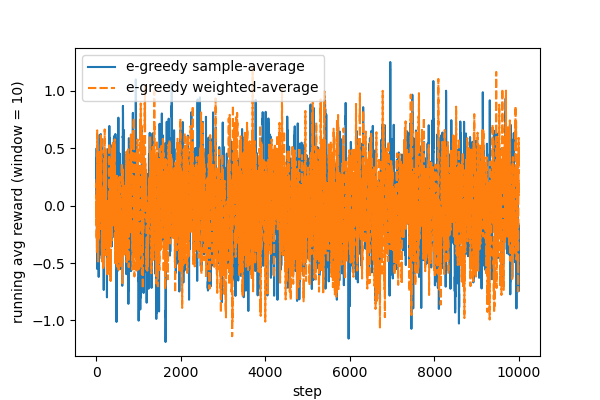

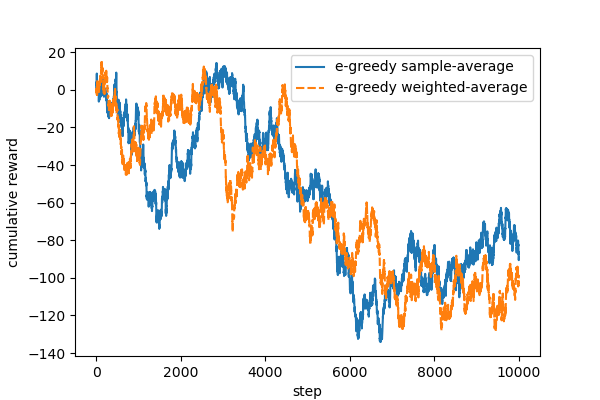

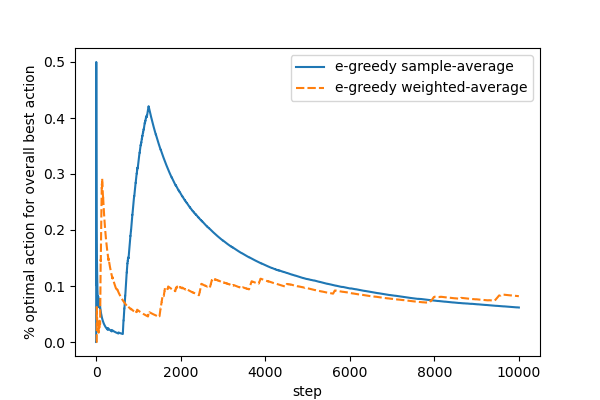

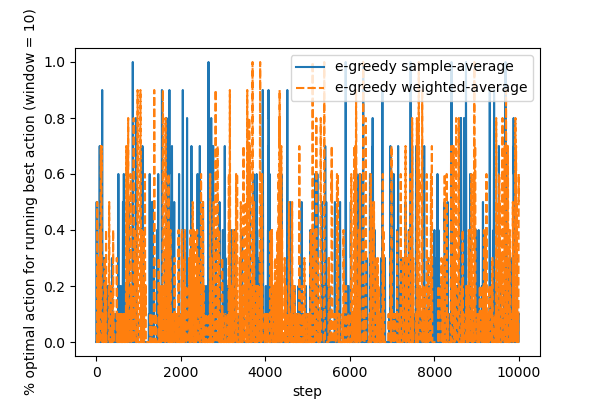

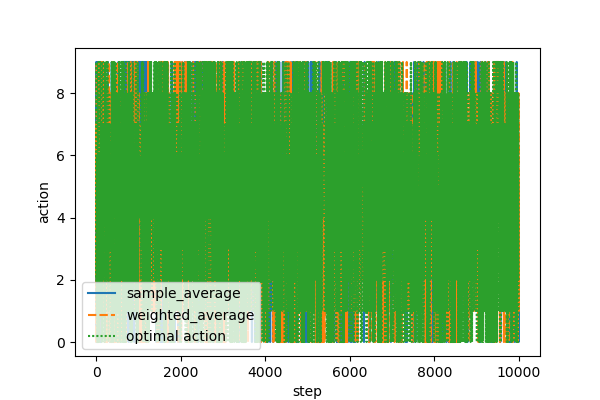

In [6]:
# Run bandit with sample-average method
b = bandits.Bandit()
b.n_arms = 10
b.n_steps = 10000
b.e_val = 0.1
nonstationarity = np.array(
    [normal(loc=0, scale=0.01, size=b.n_steps) for arm in range(b.n_arms)]
).T
b.gen_reward_data(loc=np.zeros(b.n_arms), scale=np.ones(b.n_arms))
b.reward_data += nonstationarity
b.run()

# Run bandit with weighted-average method
b.action_value_est = "weighted-average"
b.alpha = 0.1
b.run()

# Outcomes
df = b.get_outcome()

# Plot running avg reward
avg_reward = pd.DataFrame(
    {
        f"{df.action_policy.iloc[i]} {df.action_value_est.iloc[i]}": df.running_avg_reward.iloc[
            i
        ]
        for i in range(len(df))
    }
)
fig, ax = plt.subplots()
sns.lineplot(avg_reward, ax=ax)
ax.set_xlabel("step")
ax.set_ylabel(f"running avg reward (window = {b.step_win})")

# Plot cumulative reward
cum_reward = pd.DataFrame(
    {
        f"{df.action_policy.iloc[i]} {df.action_value_est.iloc[i]}": np.cumsum(
            df._rewards.iloc[i]
        )
        for i in range(len(df))
    }
)
fig, ax = plt.subplots()
sns.lineplot(cum_reward, ax=ax)
ax.set_xlabel("step")
ax.set_ylabel("cumulative reward")

# Plot overall % optimal action
pct_opt_act = pd.DataFrame(
    {
        f"{df.action_policy.iloc[i]} {df.action_value_est.iloc[i]}": df.pct_optimal_action.iloc[
            i
        ]
        for i in range(len(df))
    }
)
fig, ax = plt.subplots()
sns.lineplot(pct_opt_act, ax=ax)
ax.set_xlabel("step")
ax.set_ylabel("% optimal action for overall best action")

# Plot running % optimal action
avg_reward_data = np.zeros_like(b.reward_data)
for arm in range(b.reward_data.shape[1]):
    avg_reward_data[:, arm] = (
        np.convolve(b.reward_data[:, arm], np.ones((b.step_win,)), mode="same")
        / b.step_win
    )
opt_act = np.argmax(avg_reward_data, axis=1)
running_pct_opt_act = pd.DataFrame(
    {
        f"{df.action_policy.iloc[i]} {df.action_value_est.iloc[i]}": (
            np.convolve(
                df._actions.iloc[i] == opt_act, np.ones((b.step_win,)), mode="same"
            )
            / b.step_win
        )
        for i in range(len(df))
    }
)
fig, ax = plt.subplots()
sns.lineplot(running_pct_opt_act, ax=ax)
ax.set_xlabel("step")
ax.set_ylabel(f"% optimal action for running best action (window = {b.step_win})")

# Plot actions chosen compared to optimal action
actions_df = pd.DataFrame(
    {
        "sample_average": df._actions.iloc[0],
        "weighted_average": df._actions.iloc[1],
        "optimal action": opt_act,
    }
)
fig, ax = plt.subplots()
sns.lineplot(actions_df, ax=ax)
ax.set_xlabel("step")
ax.set_ylabel("action")

## 2.6 Optimistic Initial Values



- All action-value estimation methods discussed so far are biased by their initial estimates, $Q_1(a)$. An obvious downside of this is deciding how to set initial estimates. An upside is that they can be set to encourage exploration.
  - If all initial action-value estimates are set to values greater than the reward for those actions, each possible action will be explored at least once before any are repeated. This is known as **optimistic initial values**.

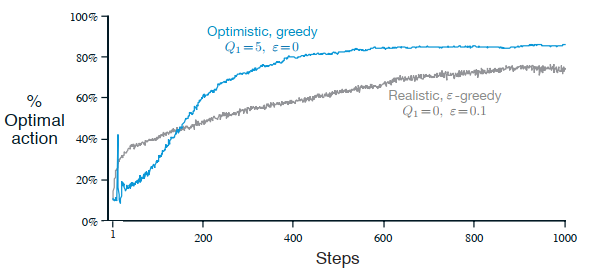

In [7]:
Image(
    r"images/ten_armed_testbed_performance_optimistic_initial_values.png",
    width=600,
    height=400,
)

### 2.6 Exercises

*Exercise 2.6: Mysterious Spikes: The results shown in Figure 2.3 (above) should be quite reliable because they are averages over 2000 individual, randomly chosen 10-armed bandit tasks. Why, then, are there oscillations and spikes in the early part of the curve for the optimistic method? In other words, what might make this method perform particularly better or worse, on average, on particular early steps?*

The spike in the optimistic case is due to the algorithm finding the optimal action and spamming it, and (because of the residual optimistic initial values for the other choices) thus reducing the value of the optimal action relative to all other actions, so the algorithm explores the others again until slowly re-converging on the optimal action.

*Exercise 2.7: Unbiased Constant-Step-Size Trick: In most of this chapter we have used sample averages to estimate action values because sample averages do not produce the initial bias that constant step sizes do (see the analysis leading to (2.6)). However, sample averages are not a completely satisfactory solution because they may perform poorly on nonstationary problems. For weighted average methods, is it possible to avoid the bias of constant step sizes while retaining their advantages on nonstationary problems?*

*One way is to use a step size of $\alpha = \beta / \bar\sigma_n$, where $\beta \in (0,1]$ is a conventional constant step size, and $\bar\sigma_n$ is a trace of one that starts at 0:
$$\begin{align}
\bar\sigma_n = \bar\sigma_{n-1} + \beta(1- \bar\sigma_{n-1}) &&\text{for } n \geq 0, \text{with } \bar\sigma_0 = 0
\end{align}$$*

*Carry out an analysis like that in (2.6) to show that $Q_n$ is an exponential recency-weighted average without initial bias.*

Using this formula for the step-size $\alpha$, $\alpha$ will eventually decay to 0 because the denominator grows relative to the numerator on subsequent rewards, satisfying $(2.7)$ for convergence.

## 2.7 Upper-Confidence-Bound Action Selection

- When using an $\epsilon$-greedy action selection, it may be better to have a heuristic to select amongst the non-greedy actions according to their potential for being optimal, rather than randomly. We can do this by taking into account both their current estimates and the uncertainity in those estimates (which we measure as a function of how many times they've been chosen). The below equation is known as Upper-Confidence-Bound (**UCB**) selection:
$$
A_t = \underset{a}{\operatorname{argmax}} \left[ Q_t(a) + c \sqrt{ln(t) \over N_t(a)}\right]
$$
  - The quantity being max'ed over is a sort of upper bound on the possible true value of $a$, with $c > 0$ a constant determining the degree of exploration, and $N_t(a)$ being the number of times $a$ has been selected prior to time $t$ (if = 0, then $a$ is considered to be a maximizing action). The full term under the square root is a measure of uncertainity (variance) in the action-value estimate for $a$.
  - Uncertainity decreases each time $a$ is chosen, and increases (at a lesser magnitude than the decrease) each time any other action is chosen. 
- UCB performs well on bandits, but is difficult to extend to more general RL settings.

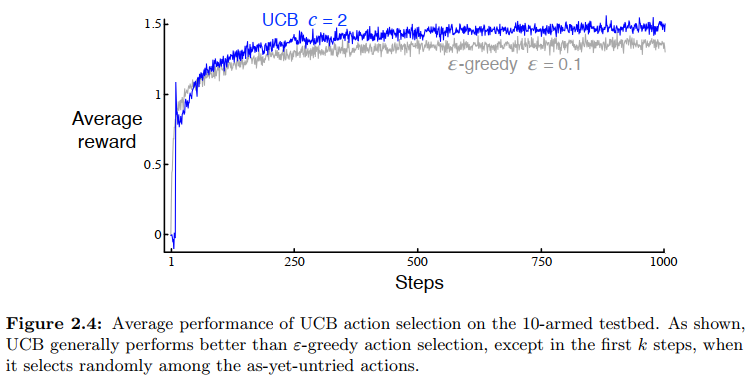

In [8]:
Image(r"images/ucb_performance.png", width=600, height=400)

### 2.7 Exercises

*Exercise 2.8: UCB Spikes: In Figure 2.4 the UCB algorithm shows a distinct spike in performance on the 11th step. Why is this? Note that for your answer to be fully satisfactory it must explain both why the reward increases on the 11th step and why it decreases on the subsequent steps. Hint: if c = 1, then the spike is less prominent*

On the 11th step, $N_t(a) = 1$, so $A_t$ will be the greedy option and reward will spike (for the previous ten steps $N_t(a) = 0$, so UCB just chooses any action that hasn't yet been chosen). 

For immediate subsequent steps, reward is most likely to decrease because $A_t$ will no longer be the greedy option because $N_t(a) = 2$ for the greedy option, and $N_t(a) = 1$ for all others. 

## 2.8 Gradient Bandit Algorithms

- So far, we've considered methods that estimate action values, and use those estimates to select actions. 
- Another approach is learning a numerical preference for each action, $H_t(a)$. These action probabilities can be determined via a **soft-max** (i.e. Gibbs or Boltzmann) distribution:
$$
\mathbb{P}\left\{A_t = a\right\} = \pi_{t}(a) = {e^{H_{t}(a)} \over \sum^{k}_{b=1} e^{H_{t}(b)}}
$$
- A learning rule for this setting is based on the idea of stochastic gradient ascent: on each step, after selecting some $A_t$ and receiving some $R_t$, update by:
$$
\begin{equation}\begin{cases}
H_{t+1}(A_t) = H_t(A_t) + \alpha(R_t - \bar{R}_t) (1 - \pi_t(A_t)) & \text{for $A_t$} \\
H_{t+1}(a) = H_t(a) + \alpha(R_t - \bar{R}_t) \pi_t(a) & \text{for $a \neq A_t$}
\end{cases}\end{equation}
$$
where $\bar{R_t}$ is the average of all rewards up through and including time $t$. 
    - $\bar{R_t}$ serves as a baseline with which reward is compared: if reward is greater than $\bar{R_t}$, then the probability of taking $A_t$ ($a \neq A_t$) again is increased (decreased), and vice versa.  
- This gradient bandit algorithm can be thought of as **stochastic gradient ascent (SGA)**
  - In standard GA (GD), you run through ALL samples in the training set to do a single update for your parameters, while in SGA (SGD), you use ONLY ONE or a SUBSET of the samples to do an update.
  

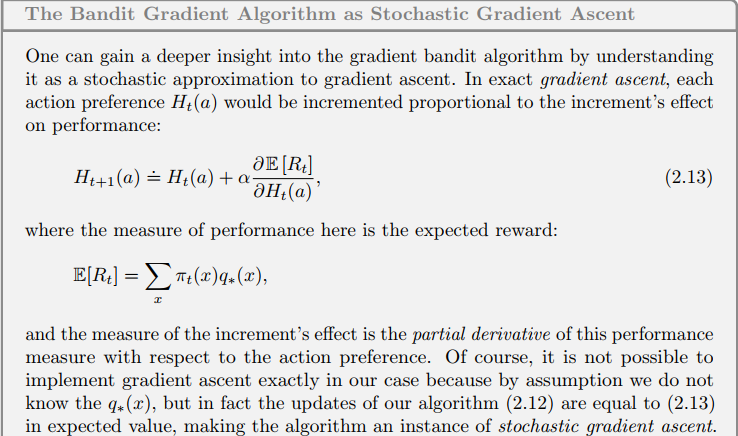

In [9]:
Image(r"images/gradient_bandit_as_sga.png", width=600, height=400)

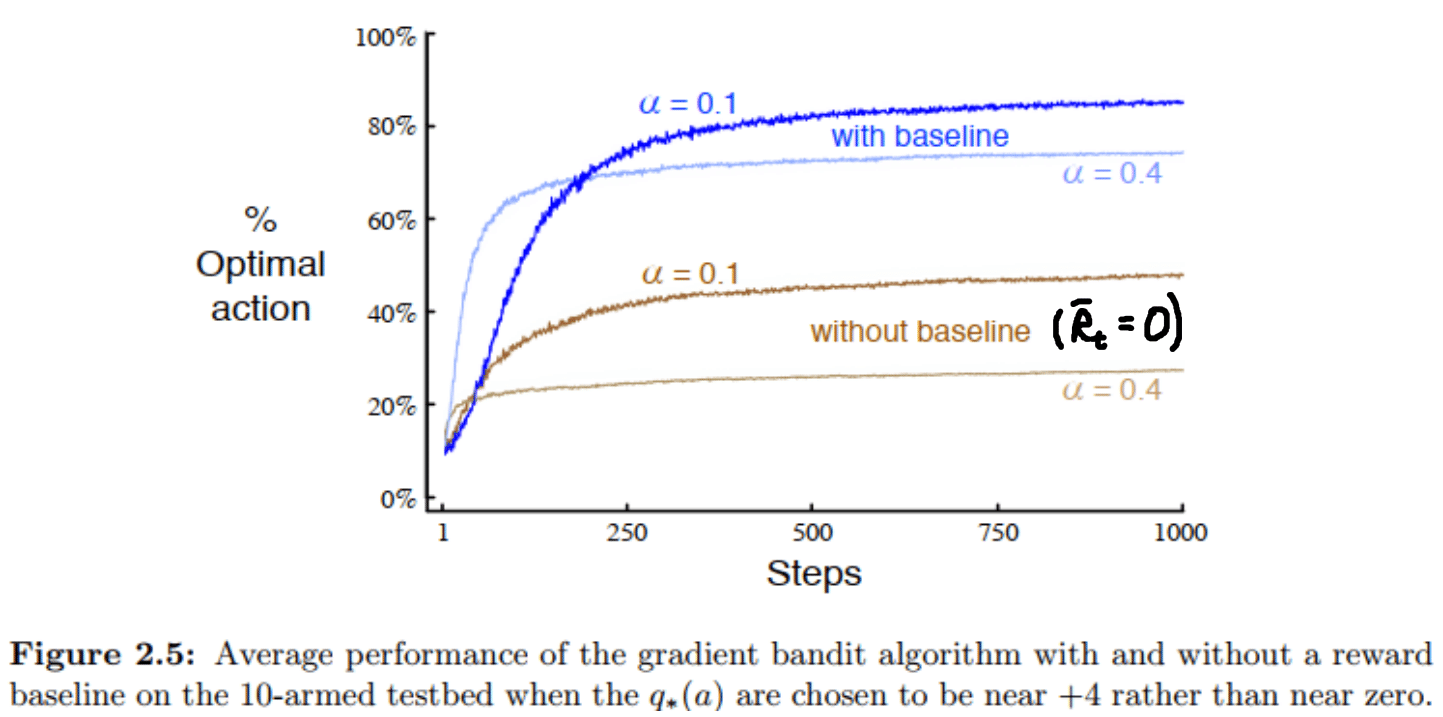

In [10]:
Image(r"images/gradient_bandit_performance.png", width=600, height=400)

### 2.8 Exercises

*Exercise 2.9: Show that in the case of two actions, the soft-max distribution is the same as that given by the logistic, or sigmoid, function often used in statistics and artificial neural networks.*

In the case of just two inputs, the softmax function
$$
{e^{z(a)} \over \sum^{k}_{b=1} e^{z(b)}} = {e^{z_1} \over e^{z_1} + e^{z_2}} = {1 \over 1 + {e^{z_2} \over e^{z_1}}} = {1 \over {1 + e^{-x}}} \qquad \text{for $z_2 = 0$}
$$

### Additional programming exercise:

Compare three agents: 1) gradient bandit; 2) e-greedy, weighted-average, unbiased, UCB selecting bandit; 3) e-greedy sample-average bandit

in two environments: 1) stationary rewards; 2) non-stationary rewards

C:\Users\jai\mambaforge\envs\rl2e\lib\site-packages\seaborn\categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
C:\Users\jai\AppData\Local\Temp\ipykernel_13968\941549008.py:45: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Text(0, 0.5, 'overall % optimal action')

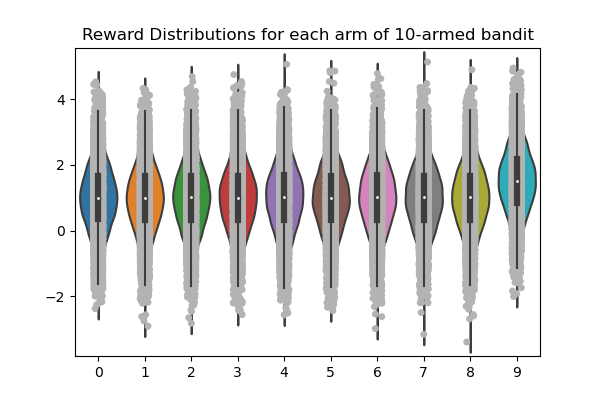

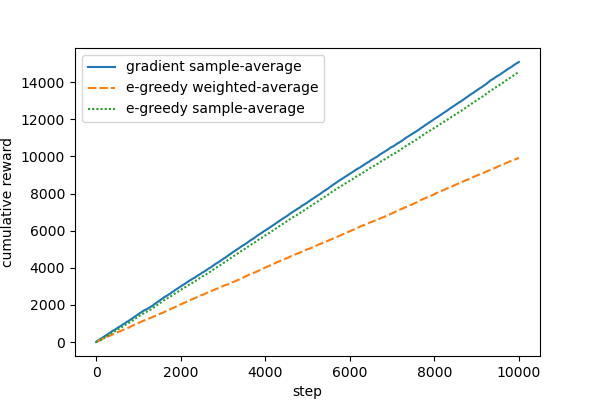

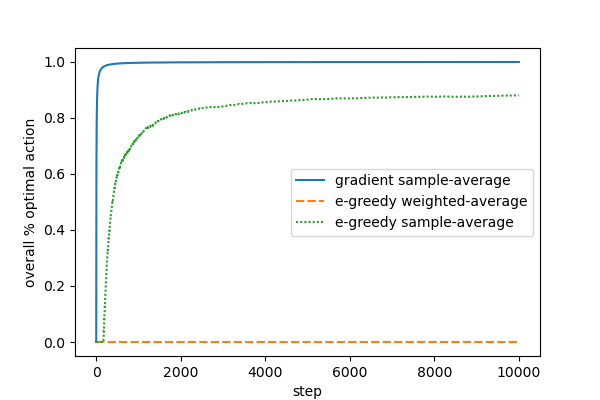

In [15]:
# Stationary example:

# <s Set up.
b = bandits.Bandit()
b.n_steps = 10000
locs = np.ones(b.n_arms)
locs[-1] += 0.5  # make last arm the best
scales = np.ones(b.n_arms)
b.gen_reward_data(loc=locs, scale=scales)
# /s>
# <s Run each agent.
# <ss gradient bandit
b.action_policy = "gradient"
b.run()
# /ss>
# <ss e-greedy, weighted-average, unbiased, UCB selecting bandit
b.action_policy = "e-greedy"
b.action_value_est = "weighted-average"
b.use_unbiased_stepsize = True
b.use_ucb = True
b.run()
# /ss>
# <ss e-greedy, sample-average bandit
b.action_value_est = "sample-average"
b.use_unbiased_stepsize = False
b.use_ucb = False
b.run()
# /ss> /s>

# <s Plot results
df = b.get_outcome()
# <ss Plot reward distributions
# ax_reward_dists = bandits.plot_reward_dists(b.reward_data)
fig, ax = plt.subplots()
bandits.plot_reward_dists(b.reward_data)
# /ss>
# <ss Plot cumulative reward
cum_reward = pd.DataFrame(
    {
        f"{df.action_policy.iloc[i]} {df.action_value_est.iloc[i]}": np.cumsum(
            df._rewards.iloc[i]
        )
        for i in range(len(df))
    }
)
# ax_reward = sns.lineplot(cum_reward)
fig, ax = plt.subplots()
sns.lineplot(cum_reward, ax=ax)
ax.set_xlabel("step")
ax.set_ylabel("cumulative reward")
# ax_reward.set_xlabel("step")
# ax_reward.set_ylabel("cumulative reward")
# /ss>
# <ss Plot overall % optimal action
pct_opt_act = pd.DataFrame(
    {
        f"{df.action_policy.iloc[i]} {df.action_value_est.iloc[i]}": df.pct_optimal_action.iloc[
            i
        ]
        for i in range(len(df))
    }
)
fig, ax = plt.subplots()
sns.lineplot(pct_opt_act, ax=ax)
ax.set_xlabel("step")
ax.set_ylabel("overall % optimal action")
# ax_opt_act = sns.lineplot(pct_opt_act)
# ax_opt_act.set_xlabel("step")
# ax_opt_act.set_ylabel("overall % optimal action")
# /ss> /s>

Text(0, 0.5, 'action')

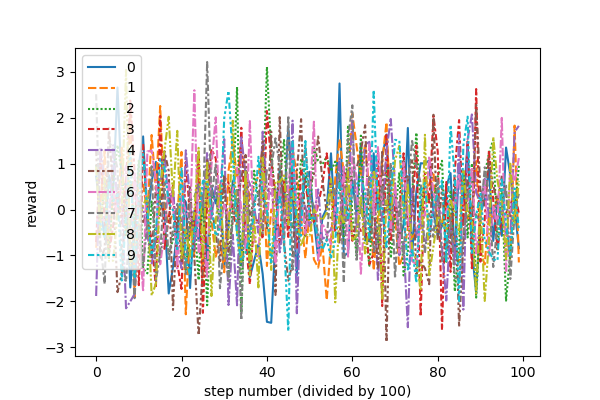

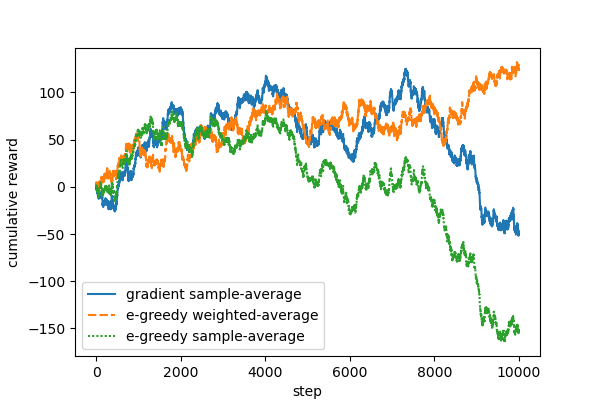

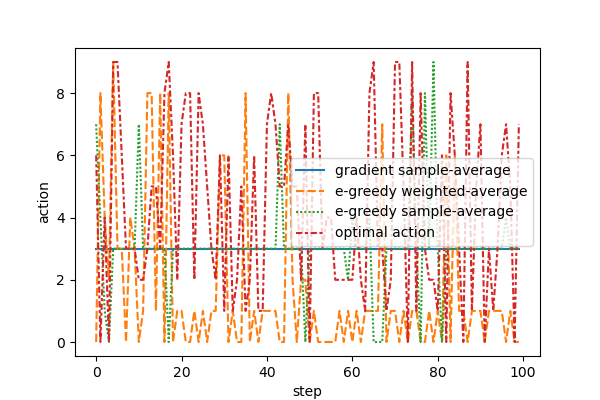

In [16]:
## Non-stationary example:
# Show how reward for each arm changes over time, in steps of 100 (lineplots)
# Run each agent and plot: 1) cumulative reward; 2) action taken vs. optimal action, in steps of 100

# <s Set up.
b = bandits.Bandit()
b.n_arms = 10
b.n_steps = 10000
b.e_val = 0.1
nonstationarity = np.array(
    [normal(loc=0, scale=0.1, size=b.n_steps) for arm in range(b.n_arms)]
).T
b.gen_reward_data(loc=np.zeros(b.n_arms), scale=np.ones(b.n_arms))
b.reward_data += nonstationarity
# /s>
# <s Run each agent.
# <ss gradient
b.action_policy = "gradient"
b.run()
# /ss>
# <ss e-greedy, weighted-average, unbiased, UCB selecting bandit
b.action_policy = "e-greedy"
b.action_value_est = "weighted-average"
b.use_unbiased_stepsize = True
b.use_ucb = True
b.run()
# /ss>
# <ss e-greedy, sample-average bandit
b.action_value_est = "sample-average"
b.use_unbiased_stepsize = False
b.use_ucb = False
b.run()
# /ss> /s>

# <s Plot results
df = b.get_outcome()
# <ss plot reward for each arm over time, in steps of 100
take_indxs = np.arange(start=0, step=100, stop=b.reward_data.shape[0])
fig, ax = plt.subplots()
sns.lineplot(np.take(b.reward_data, take_indxs, axis=0), ax=ax)
ax.set_xlabel("step number (divided by 100)")
ax.set_ylabel("reward")
# /ss>
# <ss plot cumulative reward
cum_reward = pd.DataFrame(
    {
        f"{df.action_policy.iloc[i]} {df.action_value_est.iloc[i]}": np.cumsum(
            df._rewards.iloc[i]
        )
        for i in range(len(df))
    }
)
fig, ax = plt.subplots()
sns.lineplot(cum_reward, ax=ax)
ax.set_xlabel("step")
ax.set_ylabel("cumulative reward")
# /ss>
# <ss plot action taken vs optimal action, in steps of 100
avg_reward_data = np.zeros_like(b.reward_data)
for arm in range(b.reward_data.shape[1]):
    avg_reward_data[:, arm] = (
        np.convolve(b.reward_data[:, arm], np.ones((b.step_win,)), mode="same")
        / b.step_win
    )
opt_act = np.argmax(avg_reward_data, axis=1)
actions_dict = {
    f"{df.action_policy.iloc[i]} {df.action_value_est.iloc[i]}": np.take(
        df._actions.iloc[i], take_indxs, axis=0
    )
    for i in range(len(df))
}
actions_dict["optimal action"] = np.take(opt_act, take_indxs, axis=0)
actions_df = pd.DataFrame(actions_dict)
fig, ax = plt.subplots()
sns.lineplot(actions_df, ax=ax)
ax.set_xlabel("step")
ax.set_ylabel("action")

## 2.9 Associative Search (Contextual Bandits)

- So far, we have ony considered nonassociative tasks (tasks in which there is no need to associate different actions with different situations).
    - In these tasks, the agent tries to find a single best action, even if the best action changes over time (nonstationarity) but not context.
- One example of an associative task is where there are multiple different k-armed bandit "subtasks", and one is presented at random on each step. If we could learn some distinctive clue about which bandit subtask we are presented with, we could learn a policy associating each subtask with the best action for that subtask.
    - This is called **associative search** because it involves both searching for a best action and associating this action with a particular subtask (i.e. context).
- Associative search tasks are intermediates between bandit problems and the general RL problem:
    - They are like general RL in that they involve learning a policy.
    - They are like bandits in that each actions affects only the immediate reward.
    - If actions affected the next situation _in addition to_ the immediate reward, this would be the full general RL problem.

### 2.9 Exercises

*Exercise 2.10: Suppose you face a 2-armed bandit task whose true action values change randomly from time step to time step. Specifically, suppose that, for any time step, the true values of actions 1 and 2 are respectively 0.1 and 0.2 with probability 0.5 (case A), and 0.9 and 0.8 with probability 0.5 (case B). If you are not able to tell which case you face at any step, what is the best expectation of success you can achieve and how should you behave to achieve it? Now suppose that on each step you are told whether you are facing case A or case B (although you still don’t know the true action values). This is an associative search task. What is the best expectation of success you can achieve in this task, and how should you behave to achieve it?*

In the first, nonassociative case, the best the agent can do is an E.V. reward of 0.5: 
$$
\frac{0.5(0.1 + 0.2) + 0.5(0.8 + 0.9)}{2}
$$

In the second, associative case, the agent could learn that in one subtask action 2 is preferred (with 0.2 E.V. reward), and in the other subtask action 1 is preferred (with 0.9 E.V. reward), so that the best E.V. would be 0.55:
$$
0.5(0.2 + 0.9)
$$